<a href="https://colab.research.google.com/github/pouya-mhb/DS-ML-DL-Practices/blob/main/DEAM_Classification_Final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import librosa
import numpy as np
import pandas as pd

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [01:24<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [3]:
files = os.listdir(path)
print("Files and subdirectories in the dataset:")
print(files)

Files and subdirectories in the dataset:
['DEAM_audio', 'DEAM_Annotations', 'features']


In [4]:
# Base dataset path
dataset_path = path

# Define the paths for "DEAM_audio/MEMD_audio" and the static annotations CSV
audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
static_csv = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')

# Print to verify the paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", static_csv)

# Check if the paths exist
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(static_csv):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


In [5]:
song_id = 10  # song ID
audio_path = os.path.join(audio_dir, f"{song_id}.mp3")
audio_path

'/root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio/10.mp3'

In [6]:
y, sr = librosa.load(audio_path, sr=44100, mono=True)
print(f"Audio loaded: {len(y)} samples at {sr} Hz")

Audio loaded: 1987190 samples at 44100 Hz


In [7]:
def compute_mel_spectrogram(y, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Compute mel-spectrogram and convert to dB scale."""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return librosa.power_to_db(mel_spec, ref=np.max)

def load_static_annotations(csv_path, song_id):
    """Load static annotations and extract valence and arousal."""
    df = pd.read_csv(csv_path)
    label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]
    return label

def segment_audio(y, sr, segment_length):
    """Segment audio into fixed-length chunks."""
    segment_samples = segment_length * sr
    return [y[i:i + segment_samples] for i in range(0, len(y), segment_samples)
            if len(y[i:i + segment_samples]) == segment_samples]

# Main script
print("Processing audio data...")

# Convert to mel-spectrogram
mel_spec_db = compute_mel_spectrogram(y=y, sr=sr)
print(f"Mel-spectrogram shape: {mel_spec_db.shape}")

# Load static annotations
label = load_static_annotations(static_csv, song_id)
print(f"Valence: {label[0]}, Arousal: {label[1]}")

# Segment into 5-second chunks (for consistency with CNN)
segment_length = 5  # seconds
segments = segment_audio(y, sr, segment_length)
print(f"Number of 5-second segments: {len(segments)}")

# Compute mel-spectrograms for each segment
mel_specs = np.array([compute_mel_spectrogram(segment, sr) for segment in segments])
print(f"Shape of each segment's mel-spectrogram: {mel_specs[0].shape}")


Processing audio data...
Mel-spectrogram shape: (128, 3882)
Valence: 4.0, Arousal: 4.7
Number of 5-second segments: 9
Shape of each segment's mel-spectrogram: (128, 431)


Visualizing data...


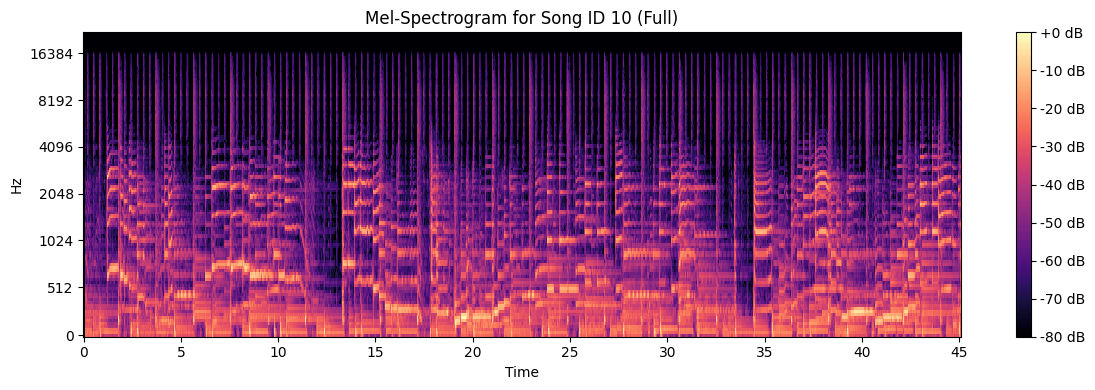

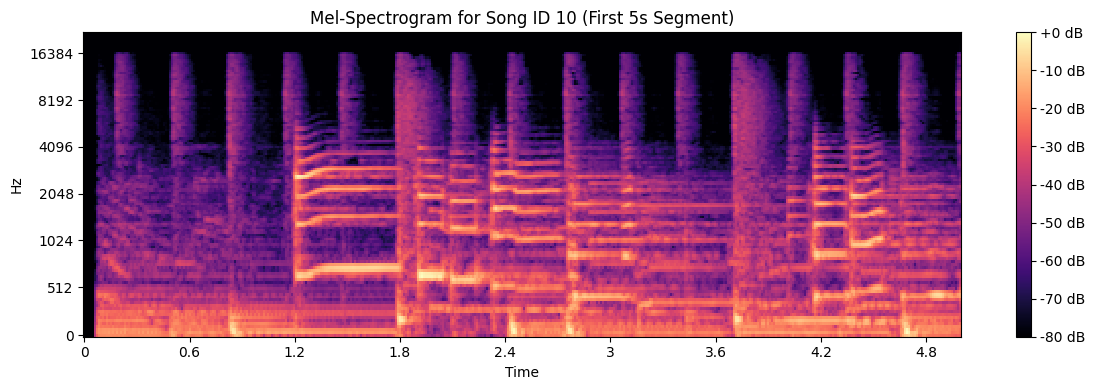

In [8]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_full_mel_spectrogram(mel_spec_db, sr, song_id, hop_length=512):
    """Visualize the full mel-spectrogram."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram for Song ID {song_id} (Full)')
    plt.tight_layout()
    plt.show()

def visualize_first_segment_mel_spectrogram(mel_spec_segment, sr, song_id, hop_length=512):
    """Visualize the mel-spectrogram of the first segment."""
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_spec_segment, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram for Song ID {song_id} (First 5s Segment)')
    plt.tight_layout()
    plt.show()

# Main script
print("Visualizing data...")

# 1. Visualize full mel-spectrogram
visualize_full_mel_spectrogram(mel_spec_db, sr, song_id)

# 2. Visualize first segment's mel-spectrogram
visualize_first_segment_mel_spectrogram(mel_specs[0], sr, song_id)

In [9]:
def process_audio_file_with_threshold(audio_path, sr=44100, segment_length=5, amplitude_threshold=0.01):
    """
    Load audio, segment it into fixed-length chunks, apply amplitude threshold,
    and return valid segments.
    """
    try:
        y_full, sr = librosa.load(audio_path, sr=sr, mono=True)
        segment_samples = segment_length * sr
        segments = []
        for i in range(0, len(y_full), segment_samples):
            segment = y_full[i:i + segment_samples]
            if len(segment) == segment_samples and np.max(np.abs(segment)) > amplitude_threshold:
                segments.append(segment)
        return segments, sr
    except Exception as e:
        print(f"Error loading audio file {audio_path}: {e}")
        return None, sr

def compute_mel_specs(segments, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Compute mel-spectrograms for a list of audio segments."""
    mel_specs = []
    for segment in segments:
        try:
            mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            mel_specs.append(mel_spec_db)
        except Exception as e:
            print(f"Error computing mel-spectrogram: {e}")
    return mel_specs

def get_labels(df, song_id):
    """Extract valence and arousal labels for a song."""
    try:
        label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]
        return label
    except Exception as e:
        print(f"Error fetching labels for song ID {song_id}: {e}")
        return None

def process_all_songs_with_limit(df, audio_dir, segment_length=5, amplitude_threshold=0.01, max_songs=20):
    """
    Process a limited number of songs: load audio, segment, apply threshold,
    compute mel-spectrograms, and store labels.
    """
    X_by_song = {}
    y_by_song = {}
    processed_count = 0  # Keep track of the number of processed songs

    for song_id in df['song_id'].values:
        if processed_count == max_songs:
            print(f"Reached the limit of {max_songs} songs. Stopping processing.")
            break

        audio_path = os.path.join(audio_dir, f"{song_id}.mp3")
        print(f"Processing song {song_id}...")

        # Process audio with threshold
        segments, sr = process_audio_file_with_threshold(audio_path, segment_length=segment_length,
                                                          amplitude_threshold=amplitude_threshold)
        if segments is None or len(segments) == 0:
            print(f"Song {song_id} skipped: No valid segments after applying threshold.")
            continue

        # Fetch labels for the song
        label = get_labels(df, song_id)
        if label is None:
            continue

        # Compute mel-spectrograms
        mel_specs = compute_mel_specs(segments, sr)
        X_by_song[song_id] = mel_specs
        y_by_song[song_id] = [label] * len(mel_specs)  # Raw labels (1-9 scale)

        processed_count += 1

    return X_by_song, y_by_song

# Main script
print("Starting data processing...")
df = pd.read_csv(static_csv)
# X_by_song, y_by_song = process_all_songs(df, audio_dir)
X_by_song, y_by_song = process_all_songs_with_limit(df, audio_dir, amplitude_threshold=0.01, max_songs=20)
print("Data loading and mel-spectrogram extraction complete.")


Starting data processing...
Processing song 2...
Processing song 3...
Processing song 4...
Processing song 5...
Processing song 7...
Processing song 8...
Processing song 10...
Processing song 12...
Processing song 13...
Processing song 17...
Processing song 18...
Processing song 19...
Processing song 20...
Processing song 21...
Processing song 22...
Processing song 24...
Processing song 25...
Processing song 31...
Processing song 32...
Processing song 35...
Reached the limit of 20 songs. Stopping processing.
Data loading and mel-spectrogram extraction complete.


In [10]:
# X_by_song

In [25]:
# y_by_song

In [11]:
import csv
import numpy as np

def save_to_csv(data_dict, filename, is_array=False):
    """
    Save a dictionary to a CSV file.

    Parameters:
    - data_dict: Dictionary to save (key: song_id, value: features/labels).
    - filename: Name of the CSV file to create.
    - is_array: If True, converts arrays to lists for easier saving.
    """
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["song_id", "data"])

        # Write data rows
        for key, value in data_dict.items():
            # If values are arrays, flatten them for readability
            if is_array:
                value = [v.tolist() for v in value]  # Convert to list
            writer.writerow([key, value])  # Write song_id and its data

# Save X_by_song (mel-spectrograms)
save_to_csv(X_by_song, 'X_by_song.csv', is_array=True)

# Save y_by_song (labels)
save_to_csv(y_by_song, 'y_by_song.csv', is_array=True)

print("Data saved to X_by_song.csv and y_by_song.csv.")


Data saved to X_by_song.csv and y_by_song.csv.


In [12]:
def discretize_labels_expanded(y_by_song, valence_thresholds=[2.5, 5.0, 7.5], arousal_thresholds=[2.5, 5.0, 7.5]):
    """
    Discretize y_by_song values into multiple categories based on refined emotional labels.

    Parameters:
    - y_by_song: Dictionary of song labels (valence, arousal).
    - valence_thresholds: Thresholds dividing valence into ranges.
    - arousal_thresholds: Thresholds dividing arousal into ranges.

    Returns:
    - expanded_labels: Dictionary with expanded emotional categories.
    """
    expanded_labels = {}

    for song_id, labels in y_by_song.items():
        categories = []
        for label in labels:  # Each label is (valence, arousal)
            valence, arousal = label

            # Classify valence and arousal into bins
            if valence > valence_thresholds[2] and arousal > arousal_thresholds[2]:
                category = "Excitement"
            elif valence > valence_thresholds[2] and arousal > arousal_thresholds[1]:
                category = "Happiness"
            elif valence > valence_thresholds[2] and arousal <= arousal_thresholds[1]:
                category = "Contentment"
            elif valence > valence_thresholds[1] and arousal <= arousal_thresholds[1]:
                category = "Serenity"
            elif valence <= valence_thresholds[0] and arousal <= arousal_thresholds[0]:
                category = "Sadness"
            elif valence <= valence_thresholds[1] and arousal > arousal_thresholds[1]:
                category = "Melancholy"
            elif valence <= valence_thresholds[1] and arousal > arousal_thresholds[2]:
                category = "Anger"
            else:  # High arousal but moderate valence
                category = "Anxiety"

            categories.append(category)

        expanded_labels[song_id] = categories

    return expanded_labels

# Apply discretization with expanded labels
expanded_y_by_song = discretize_labels_expanded(y_by_song)

# Save to CSV
save_to_csv(expanded_y_by_song, 'expanded_y_by_song.csv', is_array=False)

print("Expanded labels saved to expanded_y_by_song.csv.")


Expanded labels saved to expanded_y_by_song.csv.


In [13]:
expanded_y_by_song

{np.int64(2): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(3): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(4): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(5): ['Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy',
  'Melancholy'],
 np.int64(7): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(8): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(10): ['Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety',
  'Anxiety'],
 np.int64(12): ['Anxiety',
  'Anxiety',
  'Anxiety',
  

In [14]:
import csv
import numpy as np

def merge_features_and_labels(X_by_song, y_by_song, output_file):
    """
    Merge X_by_song (features) and y_by_song (labels) into a single dataset and save to CSV.

    Parameters:
    - X_by_song: Dictionary of song features (e.g., mel-spectrograms).
    - y_by_song: Dictionary of song labels (discrete values).
    - output_file: Path to the output CSV file.

    Output:
    - A CSV file where each row represents a segment with its label.
    """
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(["song_id", "segment_index", "features", "label"])

        # Iterate over songs and merge data
        for song_id in X_by_song.keys():
            segments = X_by_song[song_id]
            labels = y_by_song[song_id]

            # Ensure the number of segments matches the number of labels
            if len(segments) != len(labels):
                print(f"Warning: Mismatch in segments and labels for Song ID {song_id}")
                continue

            # Write each segment and its label
            for i, (segment, label) in enumerate(zip(segments, labels)):
                writer.writerow([song_id, i, segment.flatten().tolist(), label])

    print(f"Data merged and saved to {output_file}")

# Merge and save to CSV
merge_features_and_labels(X_by_song, expanded_y_by_song, "merged_dataset.csv")


Data merged and saved to merged_dataset.csv


In [15]:
import pandas as pd

# Load the merged CSV
data = pd.read_csv("merged_dataset.csv")

# Inspect the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Verify the unique labels in the dataset
print("Unique Labels:", data["label"].unique())


   song_id  segment_index                                           features  \
0        2              0  [-80.0, -80.0, -80.0, -80.0, -80.0, -41.821735...   
1        2              1  [-21.04619789123535, -22.038389205932617, -22....   
2        2              2  [-24.316959381103516, -25.55754852294922, -26....   
3        2              3  [-22.29265022277832, -26.189050674438477, -31....   
4        2              4  [-25.243080139160156, -29.027172088623047, -27...   

     label  
0  Anxiety  
1  Anxiety  
2  Anxiety  
3  Anxiety  
4  Anxiety  
song_id          0
segment_index    0
features         0
label            0
dtype: int64
Unique Labels: ['Anxiety' 'Melancholy' 'Serenity' 'Contentment']


In [16]:
import numpy as np

# Extract features and labels
features = data["features"].apply(eval).values  # Convert string representation of lists to actual lists
labels = data["label"].values

# Convert features into a NumPy array for model input
X = np.array([np.array(feature) for feature in features])

# Convert labels into numerical format for classification
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convert categorical labels to integers

print(f"Feature shape: {X.shape}, Label shape: {y.shape}")


Feature shape: (180, 55168), Label shape: (180,)


In [17]:
from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 126
Validation set size: 27
Test set size: 27


In [18]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))  # Flatten
X_val = scaler.transform(X_val.reshape(X_val.shape[0], -1))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# One-hot encode labels (if using a neural network)
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

print(f"One-hot encoded label shape: {y_train_onehot.shape}")


One-hot encoded label shape: (126, 4)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # Define a simple feedforward neural network
# model = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes in the output layer
# ])



In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Deeper fully connected neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  # Increased neurons in the first layer
    Dropout(0.3),

    Dense(256, activation='relu'),  # Added an extra dense layer with 256 neurons
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Added another dense layer with 64 neurons
    Dropout(0.3),

    Dense(32, activation='relu'),  # Added a smaller dense layer
    Dropout(0.2),

    Dense(len(label_encoder.classes_), activation='softmax')  # Final output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the deeper model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    28,246,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,421,220 (108.42 MB)

 Trainable params: 28,421,220 (108.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=50,
    batch_size=32
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3733 - loss: 4.0500 - val_accuracy: 0.7407 - val_loss: 1.2505
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5901 - loss: 8.0791 - val_accuracy: 0.7037 - val_loss: 4.0351
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5336 - loss: 12.2295 - val_accuracy: 0.8148 - val_loss: 3.3829
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5682 - loss: 13.1003 - val_accuracy: 0.7037 - val_loss: 4.3624
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5746 - loss: 10.1576 - val_accuracy: 0.7037 - val_loss: 4.2249
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5261 - loss: 10.8914 - val_accuracy: 0.7037 - val_loss: 5.9261
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6080 - loss: 9.9932 - val_accuracy: 0.7037 - val_loss: 4.3007
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6237 - loss: 8.0300 - val_accuracy: 0.7407 - val_loss: 2.15

In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("emotion_classifier_model.h5")
print("Model saved as 'emotion_classifier_model.h5'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7037 - loss: 2.8166


Test Loss: 2.816587209701538, Test Accuracy: 70.37%
Model saved as 'emotion_classifier_model.h5'


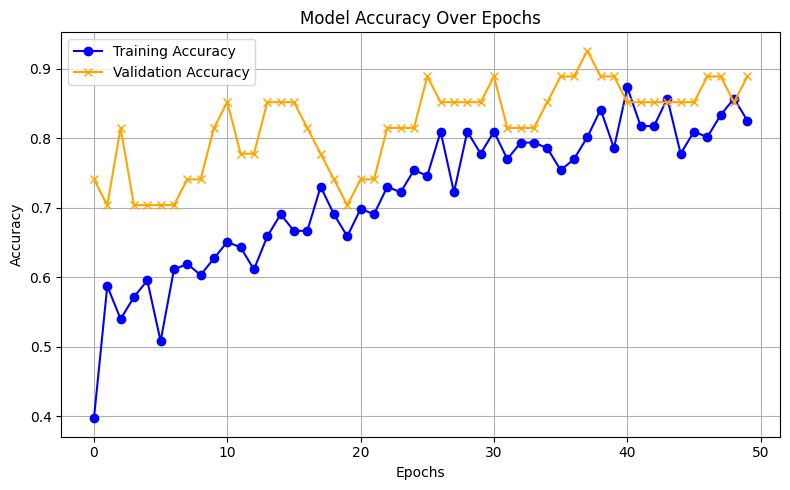

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# A Deeper Model

In [ ]:
# # Assuming y_train and y_test are integers in range [0, 7]
# y_train_onehot = to_categorical(y_train, num_classes=8)
# y_test_onehot = to_categorical(y_test, num_classes=8)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape
# import numpy as np

# from tensorflow.keras.utils import to_categorical

# print(f"y_train_onehot shape: {y_train_onehot.shape}")  # Should match (None, 8)


# # Reshape your data to match the expected input shape (128, 431, 1)
# def preprocess_features(X):
#     """
#     Reshape and normalize the input features.
#     """
#     X = X.reshape(-1, 128, 431, 1)  # Reshape to (batch_size, height, width, channels)
#     X = X.astype('float32') / 255.0  # Normalize to range [0, 1]
#     return X
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# def build_deep_cnn(input_shape, num_classes):
#     """
#     Build a deep Convolutional Neural Network for classification.

#     Parameters:
#     - input_shape: Shape of the input data (e.g., (128, 431, 1)).
#     - num_classes: Number of output classes.

#     Returns:
#     - model: Compiled deep CNN model.
#     """
#     model = Sequential()

#     # Block 1
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))  # Regularization

#     # Block 2
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))

#     # Block 3
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))

#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))  # Softmax for classification

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# # Parameters
# input_shape = (128, 431, 1)  # Match the already reshaped data
# num_classes = 8  # Number of emotional categories

# # Build and summarize the model
# deep_cnn_model = build_deep_cnn(input_shape, num_classes)
# deep_cnn_model.summary()


In [ ]:

# # Preprocess features (example: X_train, X_val, X_test)
# X_train = preprocess_features(X_train)
# X_val = preprocess_features(X_val)
# X_test = preprocess_features(X_test)


In [ ]:
# import numpy as np

# # Map 2-class labels to an extended 8-class system (example)
# new_y_train = np.random.randint(0, 8, len(y_train))  # Replace this with actual mapping logic


In [ ]:
# history = model.fit(
#     X_train, y_train_onehot,  # Ensure the labels are one-hot encoded for 8 classes
#     validation_data=(X_val, y_val_onehot),
#     epochs=50,
#     batch_size=32
# )


In [ ]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = deep_cnn_model.evaluate(X_test, y_test_onehot, verbose=1)
# print(f"Deep CNN Test Loss: {test_loss}")
# print(f"Deep CNN Test Accuracy: {test_accuracy * 100:.2f}%")

# # Plot training history (accuracy/loss)
# import matplotlib.pyplot as plt

# # Plot Accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot Loss
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# Classifing using Ensemble Learning

In [26]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initialize individual classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, kernel='rbf', random_state=42)
logreg_clf = LogisticRegression(random_state=42)

# Create a Voting Classifier (soft voting uses predicted probabilities)
voting_clf = VotingClassifier(
    estimators=[('Random Forest', rf_clf), ('SVM', svm_clf), ('Logistic Regression', logreg_clf)],
    voting='soft'
)

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Evaluate the ensemble on the test set
test_accuracy = voting_clf.score(X_test, y_test)
print(f"Ensemble Test Accuracy (Voting): {test_accuracy * 100:.2f}%")


Ensemble Test Accuracy (Voting): 92.59%


In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a Bagging Classifier
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),  # Use a decision tree as the base model
    n_estimators=50,  # Number of classifiers
    max_samples=0.8,  # Fraction of training data to sample for each classifier
    bootstrap=True,
    random_state=42
)

# Train the Bagging Classifier
bagging_clf.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = bagging_clf.score(X_test, y_test)
print(f"Bagging Test Accuracy: {test_accuracy * 100:.2f}%")


Bagging Test Accuracy: 81.48%


In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting Classifier
boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the boosting model
boosting_clf.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = boosting_clf.score(X_test, y_test)
print(f"Boosting Test Accuracy: {test_accuracy * 100:.2f}%")


Boosting Test Accuracy: 77.78%


In [29]:
from sklearn.ensemble import StackingClassifier

# Define base estimators
base_estimators = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

# Create a Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),  # Meta-model
    cv=5  # Cross-validation
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = stacking_clf.score(X_test, y_test)
print(f"Stacking Test Accuracy: {test_accuracy * 100:.2f}%")


Stacking Test Accuracy: 96.30%


In [33]:
# Define and fit each ensemble method
ensemble_methods = {
    "Voting": voting_clf,
    "Bagging": bagging_clf,
    "Boosting": boosting_clf,
    "Stacking": stacking_clf
}

# Evaluate each method
for method_name, clf in ensemble_methods.items():
    accuracy = clf.score(X_test, y_test) * 100
    print(f"{method_name} Test Accuracy: {accuracy:.2f}%")


Voting Test Accuracy: 92.59%
Bagging Test Accuracy: 81.48%
Boosting Test Accuracy: 77.78%
Stacking Test Accuracy: 96.30%


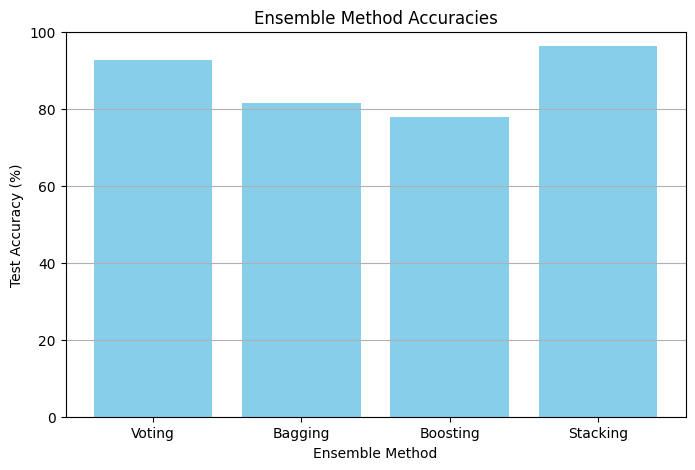

In [34]:
import matplotlib.pyplot as plt

# Example accuracies for methods
methods = ['Voting', 'Bagging', 'Boosting', 'Stacking']
accuracies = [
    voting_clf.score(X_test, y_test) * 100,
    bagging_clf.score(X_test, y_test) * 100,
    boosting_clf.score(X_test, y_test) * 100,
    stacking_clf.score(X_test, y_test) * 100
]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(methods, accuracies, color='skyblue')
plt.title('Ensemble Method Accuracies')
plt.xlabel('Ensemble Method')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()


In [35]:
from xgboost import XGBClassifier

# Create and configure the XGBoost classifier
xgb_clf = XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum depth of trees
    random_state=42
)

# Train the XGBoost model
xgb_clf.fit(X_train, y_train)

# Evaluate the XGBoost model
xgb_test_accuracy = xgb_clf.score(X_test, y_test)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy * 100:.2f}%")


XGBoost Test Accuracy: 81.48%


# Voting Classifier with XGBoost

In [36]:
from sklearn.ensemble import VotingClassifier

# Add XGBoost to the list of base classifiers
voting_clf = VotingClassifier(
    estimators=[
        ('Random Forest', rf_clf),
        ('SVM', svm_clf),
        ('Logistic Regression', logreg_clf),
        ('XGBoost', xgb_clf)
    ],
    voting='soft'
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

# Evaluate the ensemble
voting_test_accuracy = voting_clf.score(X_test, y_test)
print(f"Voting Ensemble with XGBoost Test Accuracy: {voting_test_accuracy * 100:.2f}%")


Voting Ensemble with XGBoost Test Accuracy: 88.89%


# Stacking Classifier with XGBoost

In [38]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('Random Forest', rf_clf),
        ('SVM', svm_clf),
        ('Logistic Regression', logreg_clf),
        ('XGBoost', xgb_clf)
    ],
    final_estimator=LogisticRegression(),  # Use Logistic Regression as the meta-model
    cv=5
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the stacking classifier
stacking_test_accuracy = stacking_clf.score(X_test, y_test)
print(f"Stacking Ensemble with XGBoost Test Accuracy: {stacking_test_accuracy * 100:.2f}%")


Stacking Ensemble with XGBoost Test Accuracy: 92.59%


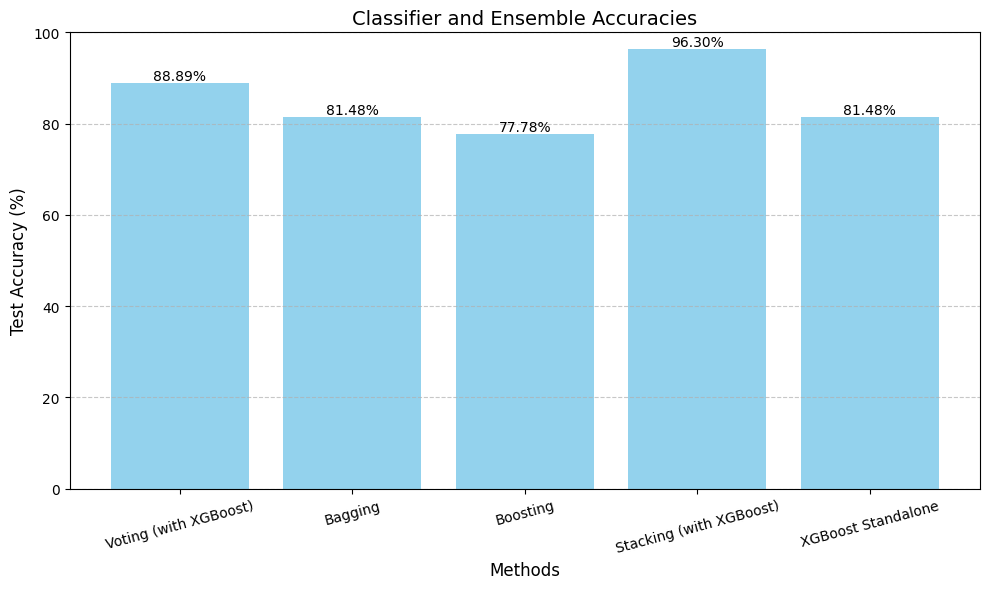

In [37]:
import matplotlib.pyplot as plt

# Example accuracies for methods
methods = ['Voting (with XGBoost)', 'Bagging', 'Boosting', 'Stacking (with XGBoost)', 'XGBoost Standalone']
accuracies = [
    voting_clf.score(X_test, y_test) * 100,
    bagging_clf.score(X_test, y_test) * 100,
    boosting_clf.score(X_test, y_test) * 100,
    stacking_clf.score(X_test, y_test) * 100,
    xgb_clf.score(X_test, y_test) * 100
]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color='skyblue', alpha=0.9)

# Add accuracy percentages on top of each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        bar.get_height(),  # Y-coordinate (height of the bar)
        f'{accuracy:.2f}%',  # Accuracy percentage
        ha='center',  # Center align
        va='bottom',  # Place label just above the bar
        fontsize=10,
        color='black'
    )

# Chart details
plt.title('Classifier and Ensemble Accuracies', fontsize=14)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0, 100)  # Adjust Y-axis if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()
